<a href="https://www.kaggle.com/code/tejasurya/unet-guide-image-segmentation?scriptVersionId=108262608" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <p style="background-color:red;color:white;font-size:22px;text-align:center;border-radius:10px 10px;font-weight:bold;border:2px solid black">Brain MRI Detector | Segmentation | Using UNet</p>

<center><img src= "https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2014/10/30/15/17/mcdc7_brain_cancer-8col.jpg" alt ="Brain-MRI" style='width:300px;'></center>

**Image source** : Mayo Clinic

# <h3 class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">Introduction</p> <a id=1></a> 
A brain tumor is a mass or growth of abnormal cells in your brain.Many different types of brain tumors exist. Some brain tumors are noncancerous (benign), and some brain tumors are cancerous (malignant). Brain tumors can begin in your brain (primary brain tumors), or cancer can begin in other parts of your body and spread to your brain as secondary (metastatic) brain tumors.

How quickly a brain tumor grows can vary greatly. The growth rate as well as the location of a brain tumor determines how it will affect the function of your nervous system.

Brain tumor treatment options depend on the type of brain tumor you have, as well as its size and location. <br>
**Source credits** : [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/brain-tumor/symptoms-causes/syc-20350084)

## <p class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">What is Image Segmentation?</p> <a id=1.1></a> <br> 
 *  The objective of the Image Segmentation is to classify each pixel of an image with the class it represents, by predicting each pixel in image. <br>
 *  Here in this notebook,we will implement the U-Net model, its a U-shaped architecture (in keras). 
We will also apply our model to a Brain MRI tumor detection problem to see how it performs.

# <p class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">Import Libraries</p> <a id=1.1></a> <br>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob

import time
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from IPython.display import Image
from skimage import io

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [2]:
img_data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
img_data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [3]:
img_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [4]:
img_data.shape

(110, 18)

In [5]:
data_path = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            mask_path = sub_dir_path + '/' + filename
            data_path.extend([dir_name, mask_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [6]:
filenames = data_path[::2]
masks = data_path[1::2]

In [7]:
df = pd.DataFrame(data={"patient_id": filenames,"img_path": masks})
df

,patient_id,img_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...
7853,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7854,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7855,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7856,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [8]:
original_img     = df[~df['img_path'].str.contains("mask")]
mask_img = df[df['img_path'].str.contains("mask")]

In [9]:
original_img,mask_img


(                 patient_id                                           img_path
 0     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 2     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 3     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 4     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 5     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 ...                     ...                                                ...
 7849  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7850  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7852  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7854  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7856  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 
 [3929 rows x 2 columns],
            

In [10]:
imgs = sorted(original_img["img_path"].values, key=lambda x : int(x[89:-4]))
masks = sorted(mask_img["img_path"].values, key=lambda x : int(x[89:-9]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Image path:", imgs[idx], "\nMask path:", masks[idx])

Image path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_2.tif 
Mask path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_2_mask.tif


In [11]:
mri_df = pd.DataFrame({"patient_id": original_img.patient_id.values,"img_path": imgs,
                           'mask_path':masks})
mri_df

,patient_id,img_path,mask_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [12]:
def get_diagnosis(img_path):
    value = np.max(cv2.imread(img_path))
    if value > 0 : 
        return 1
    else:
        return 0

In [13]:
mri_df.head()

,patient_id,img_path,mask_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [14]:
mri_df['mask'] = mri_df['mask_path'].apply(lambda x: get_diagnosis(x))

mri_df['mask_path'] = mri_df['mask_path'].apply(lambda x: str(x))
mri_df

,patient_id,img_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [15]:
mri_df.drop(columns=['patient_id'],inplace=True)

In [16]:
mri_train, mri_test = train_test_split(mri_df,test_size = 0.1)
mri_train, mri_val = train_test_split(mri_train,test_size = 0.2)

print('Training data shape is {0}'.format(mri_train.values.shape))
print('Test data shape is {0}'.format(mri_test.values.shape))
mri_train.sample(n=5)

Training data shape is (2828, 3)
Test data shape is (393, 3)


,img_path,mask_path,mask
3085,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
999,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2674,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
1143,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3627,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1


# <p class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">EDA</p> <a id=2></a> <br>

Check Balancing in Data

<AxesSubplot:title={'center':'Count of Tumour vs No Tumour'}>

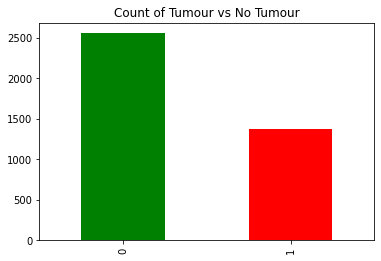

In [17]:
mri_df['mask'].value_counts().plot(kind='bar',color=['g','r'],
                title='Count of Tumour vs No Tumour')

In [18]:
mri_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

# <p class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Image Visualization</p> <a id=2></a> <br>

Visualising the Brain MRI with Tumour

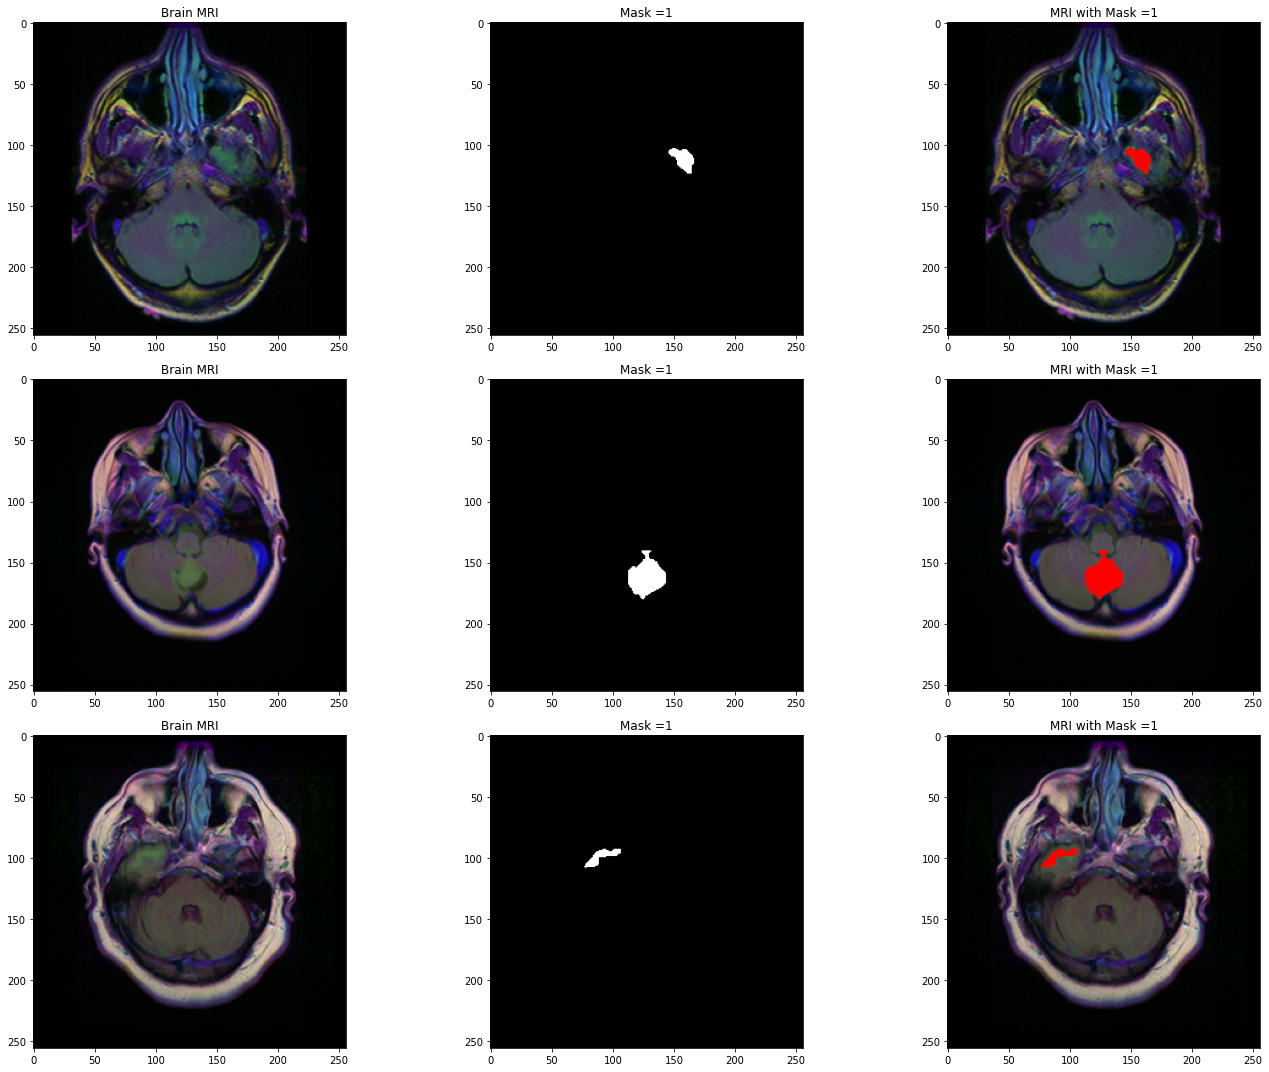

In [19]:
count = 0
i = 0
fig,axs = plt.subplots(3,3, figsize=(20,15))
for mask in mri_df['mask']:
    if (mask==1):
        img = io.imread(mri_df.img_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(mri_df.mask_path[i])
        axs[count][1].title.set_text("Mask =" + str(mri_df['mask'][i]))
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask =" + str(mri_df['mask'][i]))
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==3):
        break
        
fig.tight_layout()

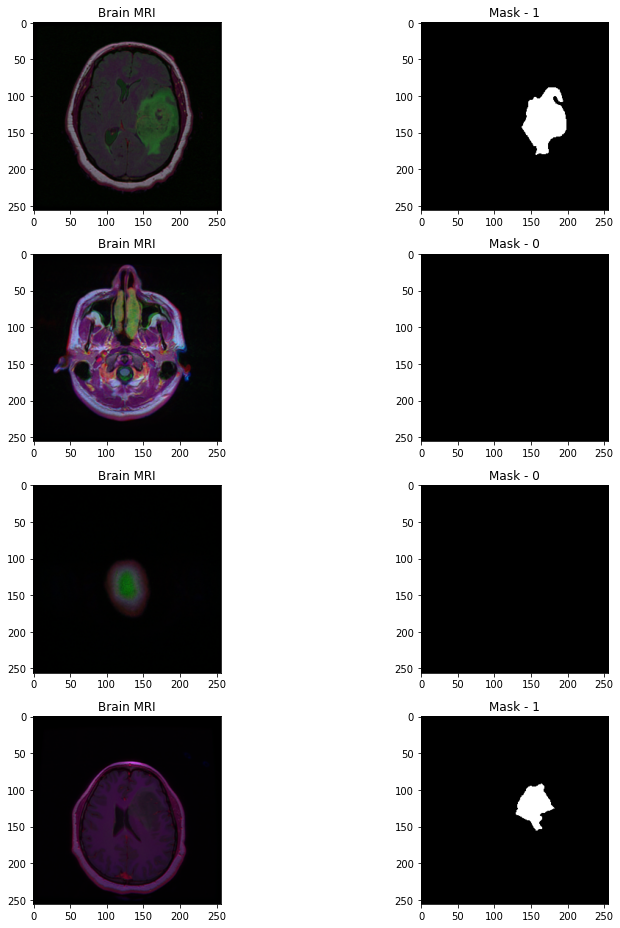

In [20]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 

fig, axs = plt.subplots(4,2, figsize=(13,13))
count = 0
for x in range(4):
  i = random.randint(0, len(mri_df)) 
  axs[count][0].title.set_text("Brain MRI") 
  axs[count][0].imshow(cv2.imread(mri_df.img_path[i])) 
  axs[count][1].title.set_text("Mask - " + str(mri_df['mask'][i])) 
  axs[count][1].imshow(cv2.imread(mri_df.mask_path[i])) 
  count += 1

fig.tight_layout()

# <p class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Data Generator</p> <a id=3></a> <br>
### Reference : **[UNet](https://github.com/zhixuhao/unet)**

In [21]:
from keras_preprocessing.image import ImageDataGenerator

In [22]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "img_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)


In [23]:
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [24]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(mri_train, 32,
                                train_generator_args,
                                target_size=(256, 256))
    
val_gen = train_generator(mri_val, 32,
                                dict(),
                                target_size=(256, 256))


# <p style="color:#FF0000;background-color:white;font-size:25px">Build UNet Model</p> <a id=4></a> <br>

<p class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">UNet Architecture</p> <a id=4.1></a>

<center><img src= "https://miro.medium.com/max/1200/1*f7YOaE4TWubwaFF7Z1fzNw.png" alt ="UNet" style='width:800px;'></center>

UNet is named after the shape of it's architecture (U - shaped). UNet model is used to solve Image Segmentation problems especially in Medical related problems.

The input layer has 572x572x1 dimension in the above architecture. The 1 column dimension specifies the input is b/w image. If the input dimension was 572x572x3 , the input image is rgb coloured image.
After the input layer,we can divide this UNet architecture into 4 parts
* Encoder Part (Contracting path)
* Upsampling2D
* Decoder part (Expanding Path)
* Skip Connection (Residual connection)


Briefly into the Details of these parts: <br>
**Encoder Part**
The initial half of the U-shaped architecture is the Contracting path(Encoder part). As the name Contracting path denotes, the dimension of the input image keeps reducing as it passes through 2 Conv2D 3X3 kernel size, ReLU activation and filters=64 followed by Maxpool2D layer (reduces size divided by 2). Now again 2 - Conv2D layers (128 filters) and 1 Maxpooling2D , 2 - Conv2D layers (256 filters) and 1 Maxpooling2D completely contracts the output dimension through layers. This is similar to the Zoom in of the image through each layer. 

**Upsampling2D**
The Upsampling2D layer upsamples the layer output dimension by duplicating the row values twice.The concatenation of the upsampling2D and contracting path happens here leading into the Expanding path.
The Upsampling layer is present after 2 conv2D layers in Decoder part, similar to presence of  Maxpooling as in Encoder part.

**Decoder Path**
The second half of the U-shaped architecture is the Expanding path(Decoder part). As the name Expanding path denotes, the dimension of the image keeps expanding as it passes through 2 Conv2D 3X3 kernel size, ReLU activation and filters=512 followed by Upsampling2D layer (duplicates size divided by 2). Now again 2 - Conv2D layers (256 filters) and 1 Upsampling2D ,2 - Conv2D layers (128 filters) and 1 Upsampling2D, 2 - Conv2D layers (64 filters) completely expands the output dimension through layers. This is similar to the Zoom in of the image through each layer. 

**Skip Connection (Residual connection)**
The Skip Connection (Residual connection) alias the identity mapping is present after each of the 2 Conv2D layers in Encoder to the corresponding same shaped dimension layer in the Decoder part . In the above architecture the copy and crop does residual connection task.The Concatenate layer does the work of adding those two layers. This skip connection doesnot harm the model in any way even in worst case but definitely benificial to the output in the model.

Finally the decoder part ends with the Output Segmentation map with filters 2. This layer is again passed through a Conv2D with Sigmoid activation and filters 1. The output classifies each pixel if tumour is present or not in it. 

### Reference : [UNet](https://github.com/zhixuhao/unet)

In [25]:
def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    bn_1 = BatchNormalization(axis=3)(conv1)
    act_1 = Activation('relu')(bn_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act_1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    bn_2 = BatchNormalization(axis=3)(conv2)
    act_2 = Activation('relu')(bn_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act_2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    bn_3 = BatchNormalization(axis=3)(conv3)
    act_3 = Activation('relu')(bn_3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act_3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    bn_4 = BatchNormalization(axis=3)(conv4)
    act_4 = Activation('relu')(bn_4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(act_4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    bn_5 = BatchNormalization(axis=3)(conv5)
    act_5 = Activation('relu')(bn_5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    bn_6 = BatchNormalization(axis=3)(conv6)
    act_6 = Activation('relu')(bn_6)
    
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    bn_7 = BatchNormalization(axis=3)(conv7)
    act_7 = Activation('relu')(bn_7)

    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    bn_8 = BatchNormalization(axis=3)(conv8)
    act_8 = Activation('relu')(bn_8)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    bn_9 = BatchNormalization(axis=3)(conv9)
    act_9 = Activation('relu')(bn_9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(act_9)

    model = model = Model(inputs=[inputs] , outputs = [conv10])    
    return model

In [26]:
model = unet()
model.summary()

2022-10-16 14:55:08.292212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 14:55:08.384469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 14:55:08.385238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 14:55:08.386921: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

<p class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">UNet Model architecture</p> <a id=5></a>


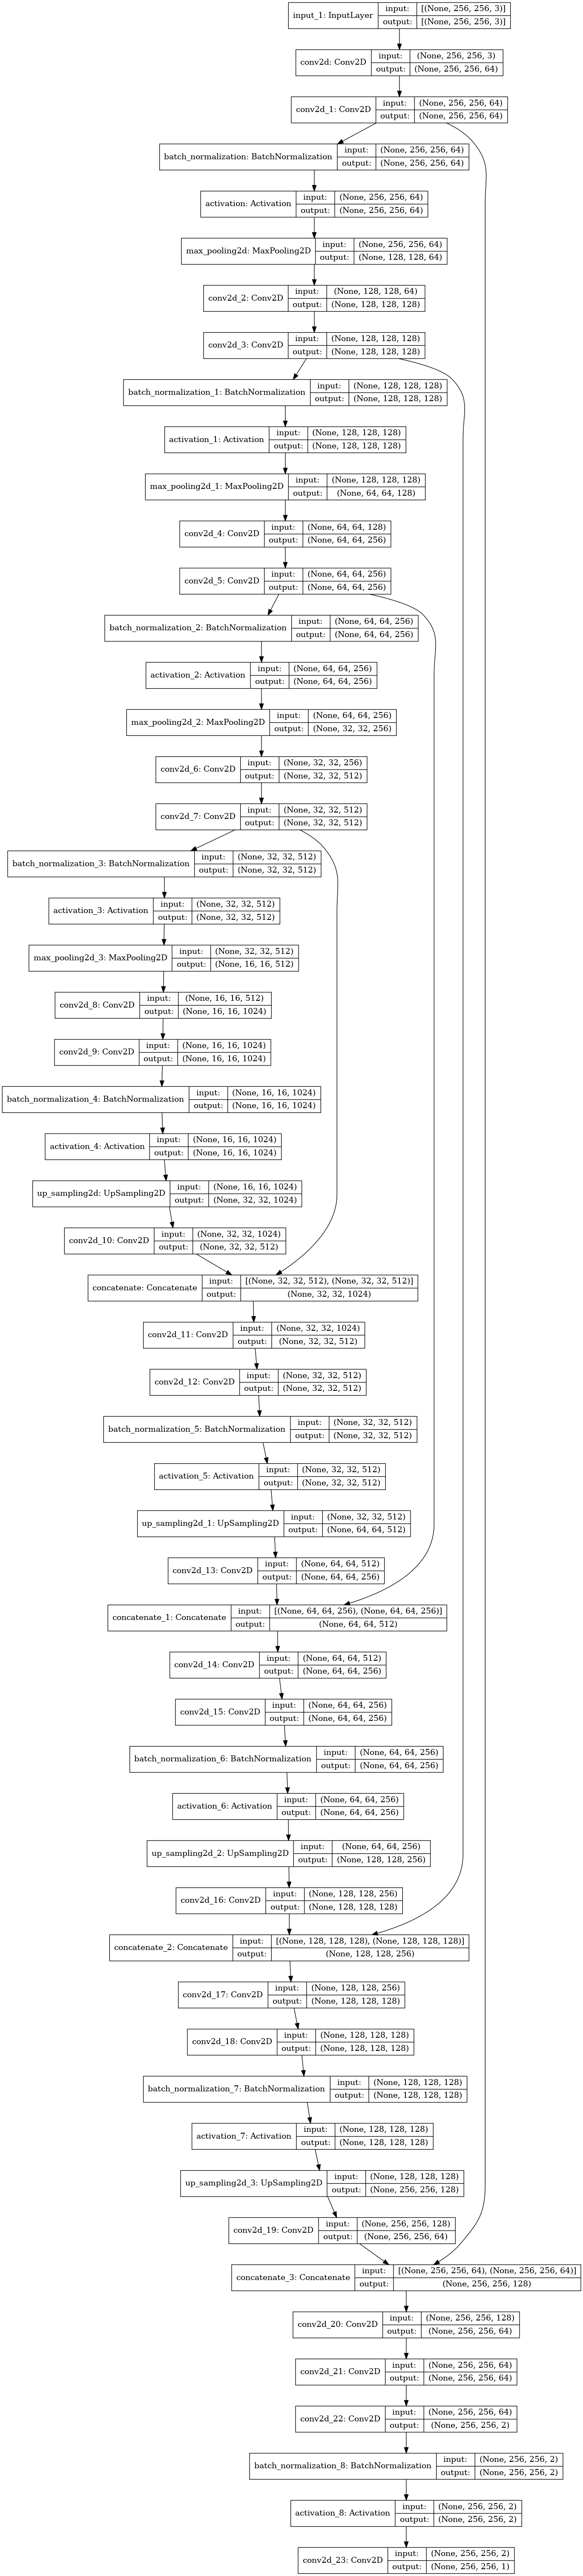

In [27]:
plot_model(model, to_file='unet_model.png', show_shapes=True)
Image("unet_model.png")

# <p class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Callbacks</p> <a id=5.2></a> <br>

The Callbacks used are 
* Learning Rate reduction
* Early Stopping
* Model Checkpoint

In [28]:
lr_reduction = ReduceLROnPlateau(monitor='val_iou',patience=8, verbose=1,
                                 factor=0.4, min_lr=0.0001)

early_stop = EarlyStopping(monitor='val_iou', min_delta=0.00001, patience=6, 
                           mode='auto', restore_best_weights=True)

model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', verbose=1,monitor='val_iou',
                                   save_best_only=True)

# <p class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Performance Metrics</p> <a id=5.2></a>


In [29]:
smooth =100
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac


In [30]:
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# <p class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Model Fit</p> <a id=5.3></a>


In [31]:
EPOCH = 70
learning_rate = 1e-3

In [32]:
model.compile(optimizer=Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-3/32, amsgrad=False), 
              loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

In [33]:
history = model.fit(train_gen,steps_per_epoch=len(mri_train) / 32,
                    epochs=EPOCH ,validation_data=val_gen,validation_steps=len(mri_val) / 32,
                    callbacks=[model_checkpoint])

Found 2828 validated image filenames.
Found 2828 validated image filenames.


2022-10-16 14:55:16.328936: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70


2022-10-16 14:55:19.168058: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-10-16 14:55:33.726990: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-10-16 14:55:33.807843: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-10-16 14:55:33.963347: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

89/88 [==============================] - ETA: 0s - loss: 0.9634 - binary_accuracy: 0.8642 - iou: 0.0188 - dice_coef: 0.0368Found 708 validated image filenames.
Found 708 validated image filenames.
88/88 [==============================] - 135s 1s/step - loss: 0.9634 - binary_accuracy: 0.8642 - iou: 0.0188 - dice_coef: 0.0368 - val_loss: 0.9741 - val_binary_accuracy: 0.9835 - val_iou: 0.0137 - val_dice_coef: 0.0269

Epoch 00001: val_iou improved from inf to 0.01373, saving model to unet_membrane.hdf5
Epoch 2/70
88/88 [==============================] - 99s 1s/step - loss: 0.9610 - binary_accuracy: 0.9225 - iou: 0.0199 - dice_coef: 0.0388 - val_loss: 0.9702 - val_binary_accuracy: 0.7956 - val_iou: 0.0162 - val_dice_coef: 0.0317

Epoch 00002: val_iou did not improve from 0.01373
Epoch 3/70
88/88 [==============================] - 99s 1s/step - loss: 0.9695 - binary_accuracy: 0.7531 - iou: 0.0156 - dice_coef: 0.0306 - val_loss: 0.9693 - val_binary_accuracy: 0.7799 - val_iou: 0.0158 - val_dic

# <p class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Save Model</p> <a id=5.4></a>


In [34]:
!mkdir -p saved_model
model.save('saved_model/my_model.h5')

In [35]:
# saving model achitecture in json file
model_json = model.to_json()
with open("UNet-seg-model.json", "w") as json_file:
    json_file.write(model_json)

# <p class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Evaluation</p> <a id=6></a>

Evaluation metrics are listed below

In [36]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'iou', 'dice_coef', 'val_loss', 'val_binary_accuracy', 'val_iou', 'val_dice_coef'])

**Loss function** :  IOU - Intersection over Union

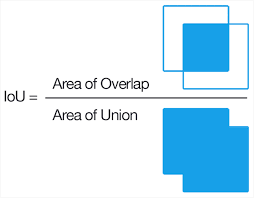

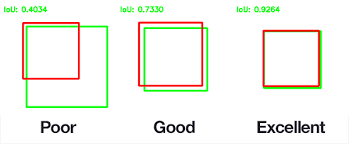

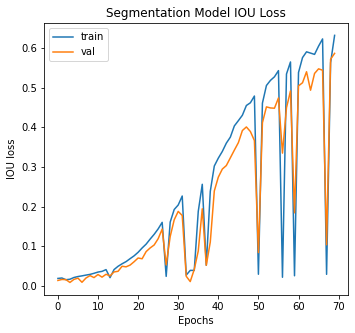

In [37]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['iou']);
plt.plot(history.history['val_iou']);
plt.title("Segmentation Model IOU Loss");
plt.ylabel("IOU loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

<p class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Prediction</p> <a id=7></a>


In [38]:
test_ids = list(mri_test.img_path)
test_mask = list(mri_test.mask_path)

In [39]:
def prediction(test, model_seg):
  
    # empty list to store results
    mask, image_id,has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.img_path:
        

        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'img_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [40]:
df_pred = prediction(mri_test, model)
df_pred

,img_path,predicted_mask,has_mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask :),0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask :),0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,"[[[[0.00236282], [0.00236282], [0.00236282], [...",1
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,"[[[[0.00236282], [0.00236282], [0.00236282], [...",1
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,"[[[[0.00236282], [0.00236282], [0.00236282], [...",1
...,...,...,...
388,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask :),0
389,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask :),0
390,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,"[[[[0.00236282], [0.00236282], [0.00236282], [...",1
391,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,No mask :),0


In [41]:
df_pred = mri_test.merge(df_pred, on='img_path')
df_pred.head()

,img_path,mask_path,mask,predicted_mask,has_mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,No mask :),0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0,No mask :),0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1,"[[[[0.00236282], [0.00236282], [0.00236282], [...",1
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1,"[[[[0.00236282], [0.00236282], [0.00236282], [...",1
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1,"[[[[0.00236282], [0.00236282], [0.00236282], [...",1


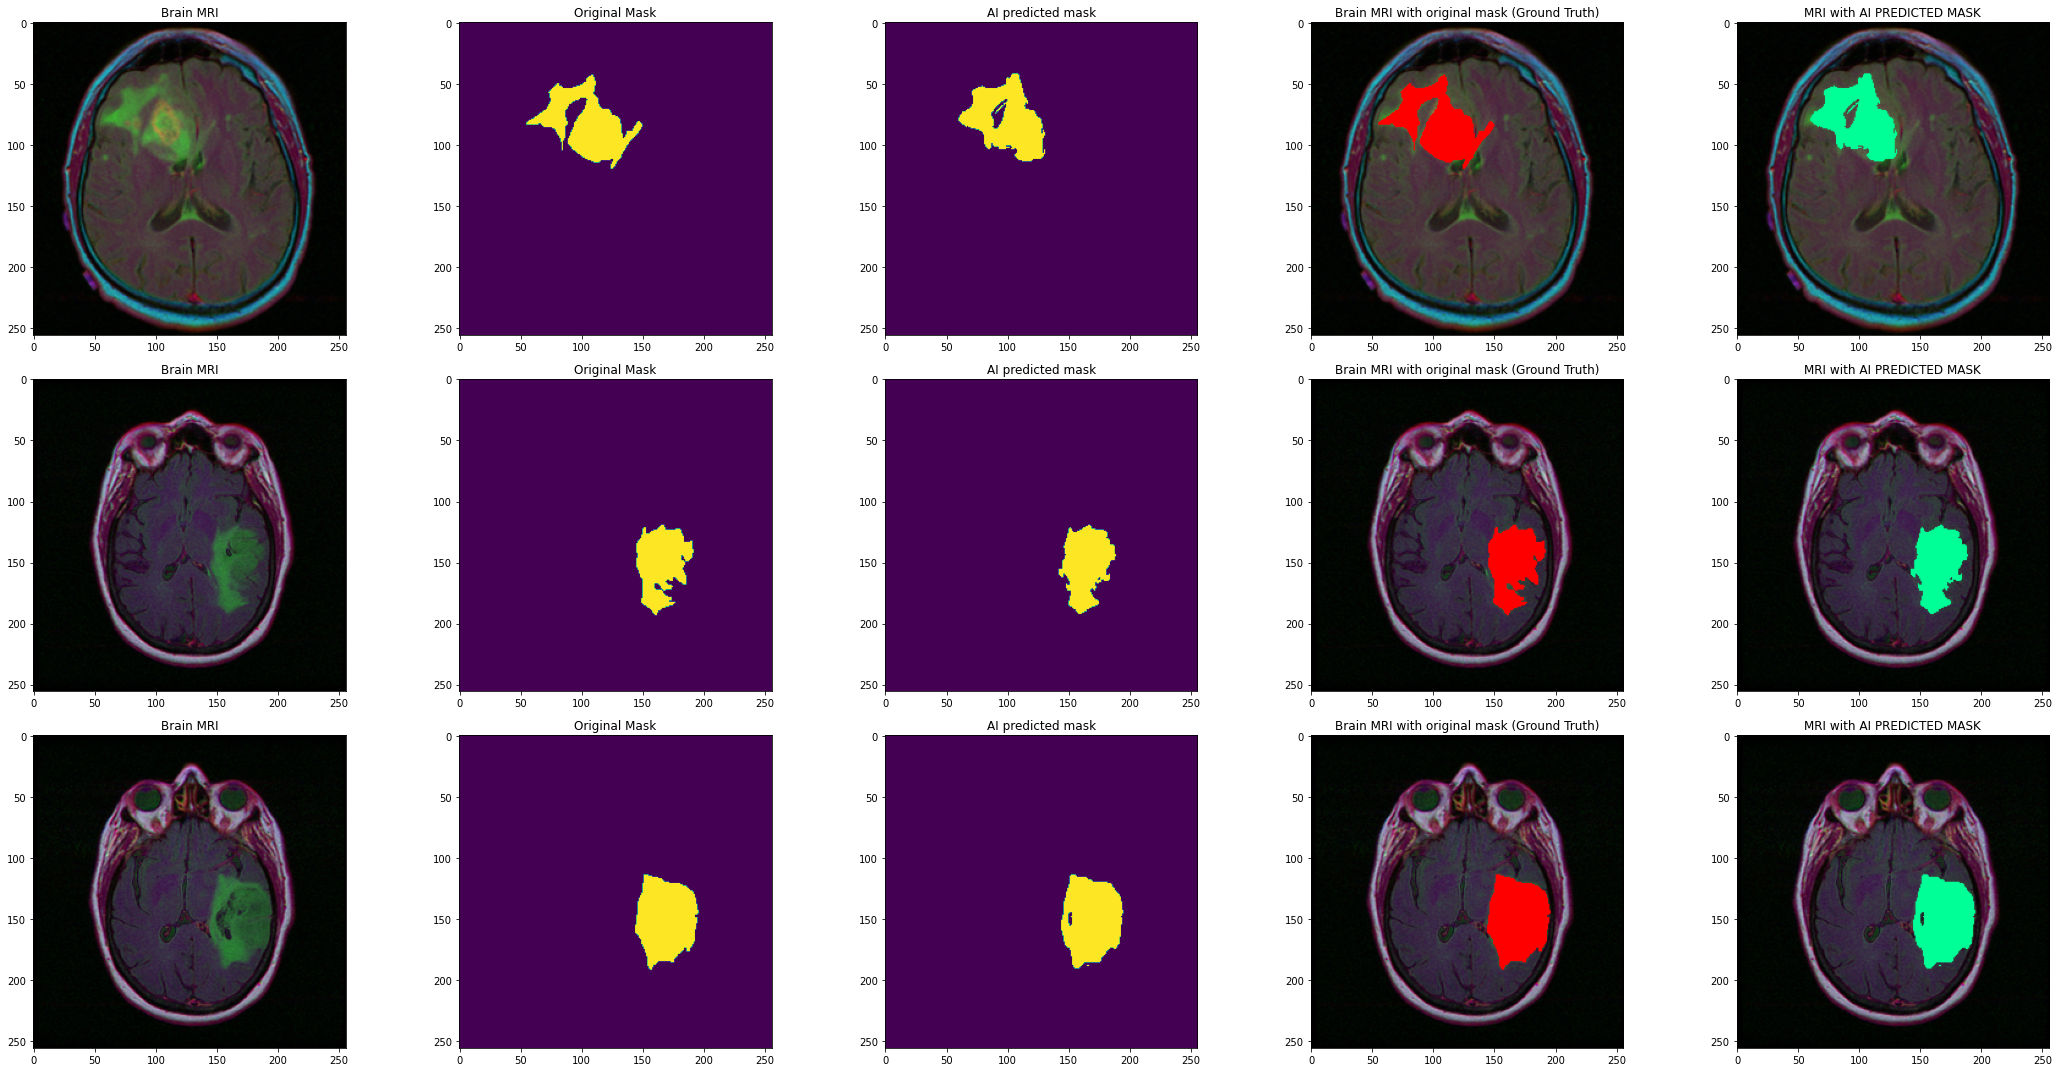

In [42]:
count = 0
fig, axs = plt.subplots(3,5, figsize=(30,15))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.img_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.img_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
        count +=1
    if (count==3):
        break

fig.tight_layout()

**Reference:** 
* [UNet model Original creator Reference link](https://github.com/zhixuhao/unet)
* [Kaggle Notebook - SAMUEL CORTINHAS](https://www.kaggle.com/code/samuelcortinhas/case-study-u-net-from-scratch#Application:-Tumor-detection)